In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass, field
from typing import List, Tuple

%matplotlib ipympl

np.set_printoptions(suppress=True)

In [3]:
x, y, h = 10, 20, 30

space = np.array([
    [1, 2, 3, 1],
    [1, 2, 3, 1],
])

In [64]:
@dataclass
class Camera:
    focal_length: float
    resolution: Tuple[int, int]
    sensor_size: Tuple[int, int]

    position: np.ndarray#=field(default_factory=np.array([0., 0., 0.]))
    angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degrees

    def __post_init__(self):
        beta, alpha, gamma = self.angle  # R_x, R_y, R_z | pitch, yaw, roll

        sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
        sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
        sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

        self.rotation = np.array([
            [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
            [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
            [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
        ])

        self.intrinsic = np.array([
            [self.focal_length*self.resolution[0]/self.sensor_size[0], 0, self.resolution[0]/2],
            [0, self.focal_length*self.resolution[1]/self.sensor_size[1], self.resolution[1]/2],
            [0, 0, 1]
        ])
        self.ratio = self.resolution[0] / self.resolution[1]
        self.fov = 84
 
    # def pixel2ray(self, pixel):
    #     pixel_ndc = (pixel + 0.5) / self.resolution
    #     # print(pixel_ndc)

    #     pixel_screen = 2*pixel_ndc - 1
    #     pixel_screen[:, 0] = pixel_ndc[:, 0]*self.ratio
    #     pixel_screen[:, 1] = 1 - 2*pixel_ndc[:, 1]
    #     # print(pixel_screen)
        
    #     pixel_screen = pixel_screen * np.tanh(np.deg2rad(self.fov/2))

    #     pixel_screen = np.concatenate([pixel_screen, -np.ones((pixel_screen.shape[0], 1))], axis=-1)

    #     ray = pixel_screen
    #     ray = ray / np.linalg.norm(ray, axis=0, keepdims=True)

    #     M = np.eye(4)  # np.zeros((4, 4))
    #     M[:3, :3] = self.rotation
    #     M[:3, -1] = self.position
    #     directional_vector = np.concatenate([ray, -np.ones((ray.shape[0], 1))], axis=-1) @ M
    #     directional_vector = directional_vector / directional_vector[:, 3:4]
    #     directional_vector = directional_vector[:, :3]
    #     directional_vector = directional_vector / np.linalg.norm(ray, axis=0, keepdims=True)

    #     return directional_vector

    def pixel2ray(self, pixel):
        pixel = np.append(pixel, np.zeros((pixel.shape[0], 1)) + 1, axis=-1)
        # pixel = pixel / self.focal_length
        translation = np.array(self.position) 
        camera_coor = pixel @ np.linalg.inv(self.intrinsic.T)
        # print('coor', camera_coor)
        # camera_coor = pixel @ np.linalg.inv(self.intrinsic).T
        world_coor = (camera_coor @ np.linalg.inv(self.rotation)) + translation
        # print('world', world_coor)
        # print(self.rotation)

        vector = world_coor - self.position
        directional_vector = vector / np.linalg.norm(vector)

        return directional_vector

# camera = Camera(16.16003, (512, 512), np.array([8, 2.5, 3]), (17.288, 232.093, 0))
camera = Camera(20., (1920, 1080), (36, 36), np.array([1, 3, 2]), (18, 0, 240))

pixels = np.array([
    [0, 0],
    [0, 1079],
    [1920, 0],
    [1920, 1079],
    [960, 540],
])
ray = camera.pixel2ray(pixels)
# print('ray', ray)

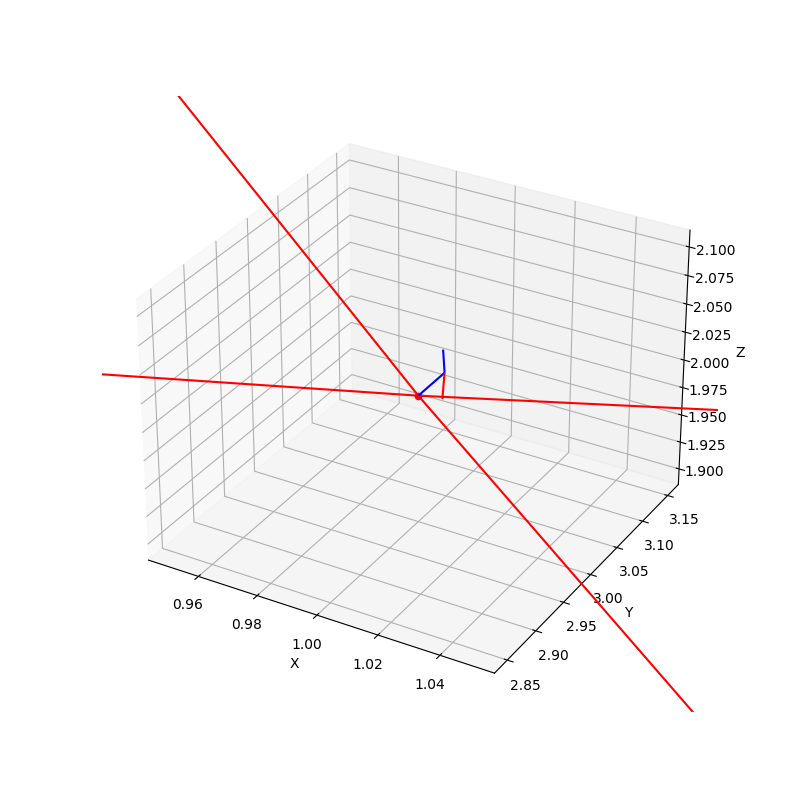

In [65]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(*camera.position, color='red')

pixels = np.array([
    [0, 0],
    [0, 1079],
    [1920, 0],
    [1920, 1079],
    [960, 540],
])
# for pixel in pixels:
#     ax.scatter(*pixel, color='teal')
rays = camera.pixel2ray(pixels)
# print(rays.shape)

stack_origin = np.stack([camera.position]*pixels.shape[0])
ax.quiver(
    stack_origin[:, 0],
    stack_origin[:, 1],
    stack_origin[:, 2],
    rays[:, 0],
    rays[:, 1],
    rays[:, 2],
    color=['red', 'red', 'red', 'red', 'blue'], length=1.0, arrow_length_ratio=.1, normalize=True
)

# ax.quiver(*camera.position, *v, color='red')

# plt.axis('off')
plt.show()

In [ ]:
beta, alpha, gamma = [30, 0, 0]  # R_x, R_y, R_z | pitch, yaw, roll

sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

np.array([
    [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
    [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
    [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
])

In [ ]:
np.stack([camera.position]*4)[:, 0]

In [ ]:
np.iinfo(np.uint8)